In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from visdom import Visdom

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torchsummary import summary

In [2]:
viz = Visdom()

Setting up a new session...


In [3]:
def init_params(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.constant_(m.bias, 0)

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*224*224, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 20),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*224*224),
            nn.Tanh()
        )
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
ae = AutoEncoder()
init_params(ae)
ae.cuda()
summary(ae, (1, 3*224*224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]     154,141,696
              ReLU-2              [-1, 1, 1024]               0
            Linear-3               [-1, 1, 256]         262,400
              ReLU-4               [-1, 1, 256]               0
            Linear-5                [-1, 1, 20]           5,140
              ReLU-6                [-1, 1, 20]               0
            Linear-7               [-1, 1, 256]           5,376
              ReLU-8               [-1, 1, 256]               0
            Linear-9              [-1, 1, 1024]         263,168
             ReLU-10              [-1, 1, 1024]               0
           Linear-11            [-1, 1, 150528]     154,291,200
             Tanh-12            [-1, 1, 150528]               0
Total params: 308,968,980
Trainable params: 308,968,980
Non-trainable params: 0
-----------------------

In [5]:
def to_img(x):
    x = 0.5*(x+1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 224, 224)
    return x

In [6]:
normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
train_ds = datasets.ImageFolder(
    'dataset/normals_cut_224_pt/',
    transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])
)

train_loader = DataLoader(
    train_ds,
    batch_size=17,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_ds = datasets.ImageFolder(
    'dataset/normals_cut_224_pt/',
    transforms.Compose([
        #transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])
)

test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [7]:
torch.backends.cudnn.benchmark = True

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 150, gamma=0.1)

In [9]:
train_loss_list = list()
for epoch in range(200):
    train_loss = 0
    
    ae.train()
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.view(imgs.size(0), -1).cuda()
        
        outputs = ae(imgs)
        loss = criterion(outputs, imgs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    
    # visualize
    viz.line(X=np.array([epoch]), Y=np.array([avg_train_loss]), win='loss', name='train_loss', update='append')
    
    print('epoch: {}, train_loss: {:.7f}'
          .format(epoch, avg_train_loss))
    
    if (epoch+1) % 20 == 0:
        pic = to_img(outputs.cpu().data[0].reshape(1, -1))
        save_image(pic, f'./result/autoencoder{epoch+1}.png')
    
    scheduler.step()    
    

epoch: 0, train_loss: 0.0138964
epoch: 1, train_loss: 0.0078510
epoch: 2, train_loss: 0.0072890
epoch: 3, train_loss: 0.0070209
epoch: 4, train_loss: 0.0069785
epoch: 5, train_loss: 0.0070379
epoch: 6, train_loss: 0.0069790
epoch: 7, train_loss: 0.0057169
epoch: 8, train_loss: 0.0057459
epoch: 9, train_loss: 0.0050052
epoch: 10, train_loss: 0.0047870
epoch: 11, train_loss: 0.0048315
epoch: 12, train_loss: 0.0047050
epoch: 13, train_loss: 0.0046699
epoch: 14, train_loss: 0.0047948
epoch: 15, train_loss: 0.0048977
epoch: 16, train_loss: 0.0048115
epoch: 17, train_loss: 0.0046243
epoch: 18, train_loss: 0.0044494
epoch: 19, train_loss: 0.0045506
epoch: 20, train_loss: 0.0045612
epoch: 21, train_loss: 0.0044742
epoch: 22, train_loss: 0.0044859
epoch: 23, train_loss: 0.0043529
epoch: 24, train_loss: 0.0043694
epoch: 25, train_loss: 0.0041818
epoch: 26, train_loss: 0.0039718
epoch: 27, train_loss: 0.0038069
epoch: 28, train_loss: 0.0035782
epoch: 29, train_loss: 0.0034144
epoch: 30, train_los

In [10]:
ae.eval()
z = list()
z_label = list()
for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.view(imgs.size(0), -1).cuda()
        features = ae.encoder(imgs).data.cpu().numpy()
        
        z.extend(features)
        z_label.extend(labels.numpy())
        
z = np.array(z, dtype=torch.dtype)
z_label = np.array(z_label, dtype=torch.dtype)
z.shape

(153, 20)

In [11]:
z

array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [12]:
feature_ae = pd.DataFrame({'label': z_label})
feature_ae

,label
0,0
1,0
2,0
3,0
4,0
...,...
148,1
149,1
150,1
151,1


In [13]:
feature_ae['type'] = feature_ae['label'].apply(lambda x: 'a' if x == 0 else 'h')
color_code = {'a': '#FF0000', 'h': '#0000FF'}
feature_ae['color'] = feature_ae['type'].apply(lambda x: color_code[x])
feature_ae

,label,type,color
0,0,a,#FF0000
1,0,a,#FF0000
2,0,a,#FF0000
3,0,a,#FF0000
4,0,a,#FF0000
...,...,...,...
148,1,h,#0000FF
149,1,h,#0000FF
150,1,h,#0000FF
151,1,h,#0000FF


In [14]:
tsne_z = TSNE(n_components=2).fit_transform(z)
tsne_z.shape

(153, 2)

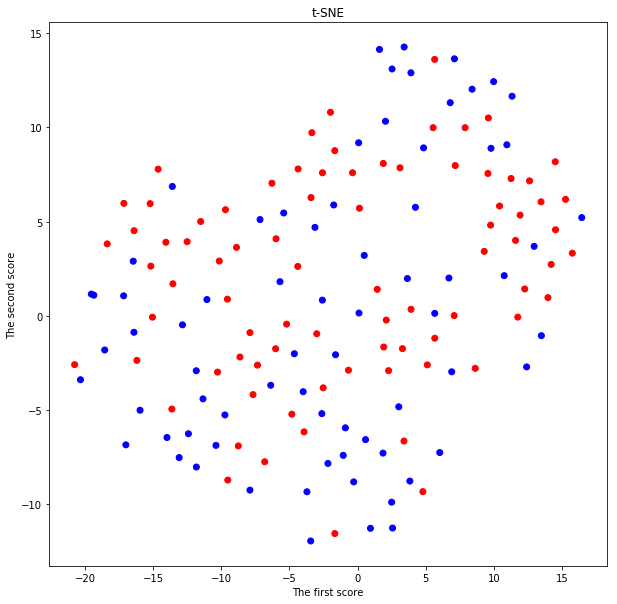

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_z[:, 0], tsne_z[:, 1], color=feature_ae['color'])
plt.title('t-SNE')
plt.xlabel('The first score')
plt.ylabel('The second score')
plt.savefig('result/tsne/ae.jpg')

In [16]:
pca_z = PCA(n_components=2).fit_transform(z)
pca_z.shape

(153, 2)

Text(0, 0.5, 'The second principal component score')

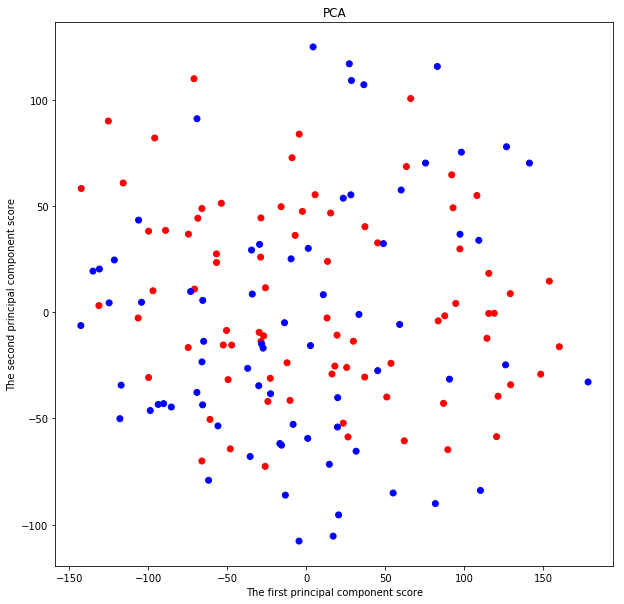

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(pca_z[:, 0], pca_z[:, 1], color=feature_ae['color'])
plt.title('PCA')
plt.xlabel('The first principal component score')
plt.ylabel('The second principal component score')

In [18]:
kmeans = KMeans(n_clusters=2).fit(z)

In [19]:
pred = kmeans.labels_
pred

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [20]:
#Acc: 47+40/153 = 0.568
#Acc: 54+35/153 = 0.582 -> 64
#Acc: 58+39/153 = 0.633 -> ReLu入れた

#Acc: 88/153 = 57.5
#Acc: 95/153 = 62.1
#Acc: 69/153 = 45.1
count = [{'a': 0, 'h': 0} for _ in range(2)]
for i, label in enumerate(pred):
    count[label][feature_ae['type'][i]] += 1
count

[{'a': 42, 'h': 41}, {'a': 39, 'h': 31}]